In [47]:
# Importing Libraries for visualization and preprocessing

import pandas as pd
import plotly.express as px
import re
import nltk
nltk.download('stopwords')
from langdetect import detect
import matplotlib.pyplot as plt

# Importing Libraries for classification
import sklearn
from sklearn.model_selection import train_test_split

# Set up TfidfTransformer to use CountVectorizer and calculate inverse document frequencies and encode tweets
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

# Importing libraries for evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lkako\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
#Load datasets, values are tab separated
#quoting = 3 is used to treat quotation marks as any other character
trn_data = pd.read_csv("mediaeval-2015-trainingset.txt", sep="\t", quoting=3)
tst_data = pd.read_csv("mediaeval-2015-testset.txt", sep="\t", quoting=3)

In [49]:
### Data Analysis ###

#Visual inspection of dataset to ensure it has loaded properly
trn_data.head()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake


In [50]:
# Examining overall volume and quality of the training dataset
trn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14483 entries, 0 to 14482
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14483 non-null  int64 
 1   tweetText   14483 non-null  object
 2   userId      14483 non-null  int64 
 3   imageId(s)  14483 non-null  object
 4   username    14483 non-null  object
 5   timestamp   14483 non-null  object
 6   label       14483 non-null  object
dtypes: int64(2), object(5)
memory usage: 792.2+ KB


In [51]:
# Examining overall volume and quality of the test dataset

tst_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3781 entries, 0 to 3780
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     3781 non-null   int64 
 1   tweetText   3781 non-null   object
 2   userId      3781 non-null   int64 
 3   imageId(s)  3781 non-null   object
 4   username    3781 non-null   object
 5   timestamp   3781 non-null   object
 6   label       3781 non-null   object
dtypes: int64(2), object(5)
memory usage: 206.9+ KB


In [52]:
# Getting the feature names
trn_data.columns

Index(['tweetId', 'tweetText', 'userId', 'imageId(s)', 'username', 'timestamp',
       'label'],
      dtype='object')

In [53]:
#Counting fake and humor labels in data
trn_data.isin(['fake', 'humor']).sum(axis=0)

tweetId          0
tweetText        0
userId           0
imageId(s)       0
username         0
timestamp        0
label         9474
dtype: int64

In [54]:
# mapping data to labels 0 and 1, label 0 being for real tweets, and label 1 for fake or humourous tweets
trn_data['label'] = trn_data['label'].map({'fake': 1, 'humor': 1, 'real': 0})
tst_data['label'] = tst_data['label'].map({'fake': 1, 'humor': 1, 'real': 0})

In [55]:
### Data Visualization ###

# Number of tweets by label
fig = px.histogram(trn_data, x='label', title='Number of tweets by label', template='seaborn')
fig.update_xaxes(title='Label', categoryorder='category descending')
fig.update_yaxes(title='Number of tweets')

fig.show()

In [56]:
# Calculate tweet lengths
trn_data['length'] = trn_data['tweetText'].str.len()

# Create and show histogram
fig = px.histogram(trn_data, x='length', template='seaborn', title='Length of tweets')
fig.update_layout(xaxis=dict(categoryorder='category descending', title='Length'), yaxis=dict(title='Tweets'))
fig.show()

In [57]:

### Preprocessing ###


In [58]:
# Creating a method for most relevant preprocessing steps
def my_preprocess(text):
    # Lower casing
    text = text.lower()
    # URL and noise removal
    text = re.sub(r'http.*', '', text)
    text = re.sub(r'[^a-zA-Z ]+', '', text)
    return text

# Applying basic preprocessing to trn_data and tst_data
trn_data['clnTweet'] = trn_data['tweetText'].apply(my_preprocess)
tst_data['clnTweet'] = tst_data['tweetText'].apply(my_preprocess)

In [59]:
# Checking for identical tweets
trn_data['clnTweet'].duplicated().sum()

3303

In [60]:
# Removing duplicate rows
trn_data = trn_data.drop_duplicates(subset=['clnTweet'], keep='first').reset_index(drop=True)


In [61]:
# Checking for identical tweets
trn_data['clnTweet'].duplicated().sum()

0

In [62]:
# Source: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b | Slowikowski, K., 2018. Remove All Traces Of Emoji From A Text File..
# Slightly modified to appear more concise 
def remove_emoji(text):
    return re.sub("[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF\U00002702-\U000027B0\U000024C2-\U0001F251]+", '', text, flags=re.UNICODE)

trn_data['clnTweet'] = trn_data['clnTweet'].apply(remove_emoji)
tst_data['clnTweet'] = tst_data['clnTweet'].apply(remove_emoji)

In [63]:
# Stop word removal
from nltk.corpus import stopwords

stopwords_set = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwords_set])

trn_data['clnTweet'] = trn_data['clnTweet'].apply(remove_stopwords)
tst_data['clnTweet'] = tst_data['clnTweet'].apply(remove_stopwords)

In [64]:
# Checking lengths of clnTweet column
trn_data['cleanlength'] = trn_data['clnTweet'].apply(len)

In [65]:
def create_histogram(data, x_column, title, xaxis_title, yaxis_title, xaxis_range, nbins=80):
    fig = px.histogram(data, x=x_column, template='seaborn', title=title,
                       nbins=nbins)

    fig.update_xaxes(title_text=xaxis_title, tickvals=list(range(0, xaxis_range + 1, 5)), showgrid=True)
    fig.update_yaxes(title_text=yaxis_title, showgrid=True)
    fig.update_layout(xaxis_range=[0, xaxis_range], showlegend=False)

    return fig

In [66]:
histogram_fig = create_histogram(trn_data, x_column='cleanlength',
                                 title='Distribution of Tweet Lengths',
                                 xaxis_title='Clean Length',
                                 yaxis_title='Number of Tweets',
                                 xaxis_range=120)

histogram_fig.show()

In [67]:
# Removing tweets that are shorter than 4 characters for langdetect
min_tweet_length = 4
trn_data = trn_data[trn_data['cleanlength'] >= min_tweet_length]

In [68]:
histogram_fig = create_histogram(trn_data, x_column='cleanlength',
                                 title='Distribution of Tweet Lengths',
                                 xaxis_title='Clean Length',
                                 yaxis_title='Number of Tweets',
                                 xaxis_range=120)

histogram_fig.show()

In [69]:
# Detect languages in tweets
def detect_language(text):
    return detect(text)

trn_data['language'] = trn_data['clnTweet'].apply(detect_language)

In [70]:
# Plot a histogram of tweet language
fig = px.histogram(trn_data, title='Number of tweets by language', x='language', template='seaborn')
fig.update_xaxes(title='Language', categoryorder='category descending')
fig.update_yaxes(title='Number of tweets')
fig.show()


In [71]:
# Creating a new dataframe to plot a pie chart

lang_counts = trn_data['language'].value_counts()
threshold = 220
langpd = pd.DataFrame({'language': lang_counts.index, 'counts': lang_counts}).reset_index(drop=True)
langpd['language'] = langpd.apply(lambda row: 'Other' if row['counts'] < threshold else row['language'], axis=1)

In [72]:
# Plotting a pie chart of 4 main languages in entry tweets
fig = px.pie(langpd, values='counts', names='language', title='Pie Chart of Languages in Entry Tweets', 
             template='seaborn', hole=0.3)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [73]:
englishtrn_data = trn_data[trn_data['language'] == "en"]

In [74]:
### Feature selection ###
# The two features selected based on online research are the length of tweets and the frequency of words
# Since length of tweets is not conclusive enough, frequency of words is chosen as the main feature instead

In [75]:
# Analyse length of fake posts
fig = px.histogram(englishtrn_data[englishtrn_data['label'] == 1], x='cleanlength', template='seaborn', title='Length of fake/humor tweets')
fig.update_xaxes(categoryorder='category descending', title='Number of characters').update_yaxes(title='Tweets')
fig.show()

In [76]:
# Analyse length of real posts
fig = px.histogram(englishtrn_data[englishtrn_data['label'] == 0], x='cleanlength', template='seaborn', title='Length of real tweets')
fig.update_xaxes(categoryorder='category descending', title='Number of characters').update_yaxes(title='Tweets')
fig.show()

In [77]:
### Classification ###

In [78]:
# train_test_split is used to split the dataset into training and testing sets
X_train, _, y_train, _ = train_test_split(englishtrn_data['clnTweet'], englishtrn_data['label'], test_size=0.01, random_state=1)


In [79]:
# Pipeline is setup with multinomial naive bayes classifier

ppl = make_pipeline(
    CountVectorizer(), # Convert text to a matrix of token counts
    TfidfTransformer(), # Transform a count matrix to a normalized term-frequency or term-frequency times inverse document-frequency representation
    MultinomialNB()
)

# Fit the model
multinomial_mdl = ppl.fit(X_train, y_train)

# Make predictions
multinomial_pred = multinomial_mdl.predict(tst_data['clnTweet'])

In [80]:
# Pipeline is setup with stochastic gradient descent classifier

ppl = make_pipeline(
    CountVectorizer(), # Convert text to a matrix of token counts
    TfidfTransformer(), # Transform a count matrix to a normalized term-frequency or term-frequency times inverse document-frequency representation
    SGDClassifier()
)

# Fit the model
stochastic_mdl = ppl.fit(X_train, y_train)

# Make predictions
stochastic_pred = stochastic_mdl.predict(tst_data['clnTweet'])

In [81]:
### Evaluation ###
# 1- Confusion Matrices
# 2- F1 scores

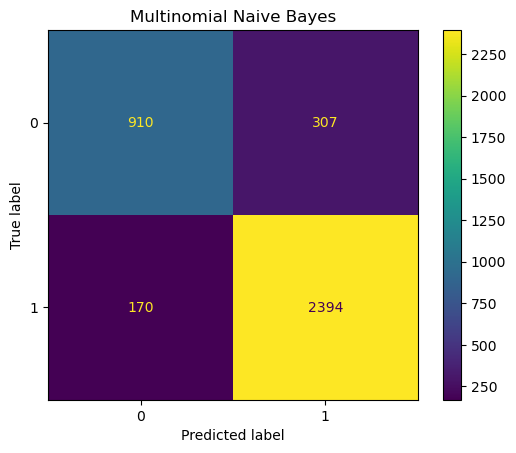

In [82]:
cm = confusion_matrix(tst_data['label'], multinomial_pred, labels = multinomial_mdl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= multinomial_mdl.classes_)
disp.plot()
plt.title("Multinomial Naive Bayes")
plt.show()

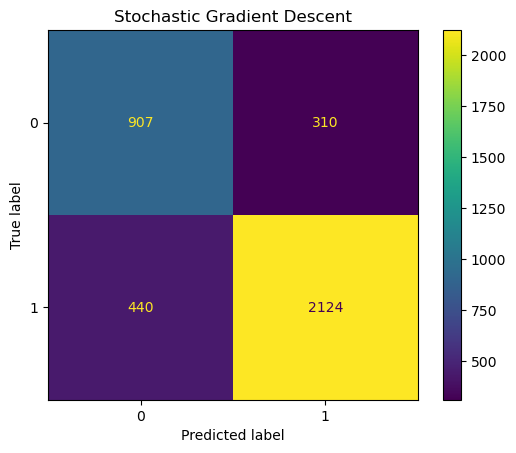

In [83]:
cm = confusion_matrix(tst_data['label'], stochastic_pred, labels = stochastic_mdl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= stochastic_mdl.classes_)
disp.plot()
plt.title("Stochastic Gradient Descent")
plt.show()

In [84]:
f1_multinomial = f1_score(tst_data['label'], multinomial_pred, average="micro")
print(f1_multinomial)

0.8738428987040465


In [85]:
f1_stochastic = f1_score(tst_data['label'], stochastic_pred, average="micro")
print(f1_stochastic)

0.8016397778365512


In [86]:
# All F1 scores written into a panda Dataframe, sorted by highest to lowest F1 score

df1 = pd.DataFrame({'Classifier': ['Multinomial Naive Bayes', 'Stochastic Gradient Descent'], 'F1 Score': [f1_multinomial, f1_stochastic]})

print(df1)


                    Classifier  F1 Score
0      Multinomial Naive Bayes  0.873843
1  Stochastic Gradient Descent  0.801640


In [87]:
# Graph of F1 scores for visual comparison

graph = px.bar(df1,  x='Classifier', y='F1 Score', template='seaborn', title='Model Accuracy')
graph.update_layout(yaxis_range=[0.70,0.90])

graph.show()